In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import nn,optim
import torchvision
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset



In [3]:
batch_size=64
learning_rate=0.01
num_classes=10
epochs=15

In [4]:
raw_train_data = datasets.EMNIST(root="data", split="balanced", train=True, download=False)

#compute mean and std for normalization
mean = raw_train_data.data.float().mean() / 255
std = raw_train_data.data.float().std() / 255

print(mean,std)

tensor(0.1751) tensor(0.3332)


In [5]:
#Prepare Data

transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=[mean], std=[std])])

train_set=datasets.EMNIST(root='./data', split='balanced', download=False,train=True,transform=transform)
train_data=DataLoader(train_set,batch_size=batch_size,shuffle=True)

val_set=datasets.EMNIST(root='./data', split='balanced', download=False,transform=transform)
val_data=DataLoader(val_set,batch_size=batch_size)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


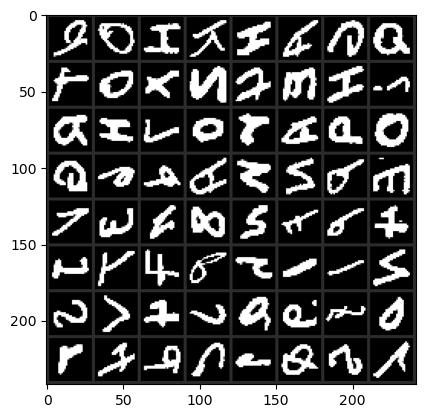

tensor([38,  0, 17, 20, 17, 10, 16, 26, 29,  0, 33, 35,  4, 14, 17, 18, 27, 17,
         7,  0, 45, 10,  9, 24, 16,  6, 38, 10, 43, 23, 25, 14, 31, 35, 43,  8,
        23, 15, 25,  4, 19, 29,  7, 25, 42,  1, 21, 23, 28, 31,  4, 19, 36, 41,
        15, 13, 29,  4, 38, 12, 41, 26,  5, 21])


In [6]:
def imshow(img, mean, std):
    img = img / std + mean # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_data)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images), 0.1751, 0.3332)
print(labels)

In [7]:
#Model
import torch.nn.functional as F
class nnModel(nn.Module):
    def __init__(self,num_classes=47,dropout_rate=0):
        super(nnModel,self).__init__()
        self.conv1=nn.Sequential(nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
                                 nn.ReLU())
        self.conv2=nn.Sequential(nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
                                 nn.ReLU(),nn.MaxPool2d(kernel_size=2,stride=2))
        self.dropout=nn.Dropout(dropout_rate)
        self.fc1=nn.Linear(14*14*64,256)
        self.fc2=nn.Linear(256,num_classes)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)#flatten
        out = self.fc1(out)
        out = F.relu(out)
        out = self.dropout(out)
        output=F.log_softmax(self.fc2(out),dim=1)
        return output
        

In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
from torchsummary import summary
model=nnModel().to(device)
summary(model,input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 64, 28, 28]          18,496
              ReLU-4           [-1, 64, 28, 28]               0
         MaxPool2d-5           [-1, 64, 14, 14]               0
            Linear-6                  [-1, 256]       3,211,520
           Dropout-7                  [-1, 256]               0
            Linear-8                   [-1, 47]          12,079
Total params: 3,242,415
Trainable params: 3,242,415
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.25
Params size (MB): 12.37
Estimated Total Size (MB): 13.62
----------------------------------------------------------------


In [10]:
#optimizer and loss function
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)

In [11]:
#Training

def train(model,loss_function,optimizer,train_loader=train_data,epoch=None,num_epochs=15):
    num_steps = len(train_loader)
    model.train()

    total_loss = 0
    total=0
    correct=0

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        # Zero gradients
        optimizer.zero_grad()
        # Forward
        outputs = model(images)
        # Compute Loss
        loss = loss_function(outputs, labels)
        # Backward
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        # Print Log
        if (i + 1) % 100 == 0:
            print("Epoch {}/{} - Step: {}/{} - Loss: {:.4f}".format(
                    epoch, num_epochs, i, num_steps, total_loss / (i + 1)))
    train_accuracy = correct / total
    print("Epoch {} - Train Accuracy: {:.4f} - Train Loss: {:.4f}".format(
        epoch, train_accuracy, total_loss / num_steps))

In [12]:
def validating(model, loss_function, val_loader=val_data, epoch=None):
    model.eval()
    val_losses = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for _, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_losses += loss.item()
            predicted = torch.max(outputs, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # In validation accuracy và loss
    print("Epoch {} - Validation Accuracy: {:.4f} - Validation Loss: {:.4f}".format(
        epoch,
        correct / total,
        val_losses / len(val_loader)))

In [13]:
def train_and_validate(model,optimizer,loss_function,num_epochs=15):
    for epoch in range(num_epochs):
        train(model,loss_function,optimizer,epoch=epoch+1)
        validating(model,loss_function,val_loader=val_data,epoch=epoch+1)

In [14]:
train_and_validate(model,optimizer,loss_function)

Epoch 1/15 - Step: 99/1763 - Loss: 2.5868
Epoch 1/15 - Step: 199/1763 - Loss: 1.9612
Epoch 1/15 - Step: 299/1763 - Loss: 1.6566
Epoch 1/15 - Step: 399/1763 - Loss: 1.4515
Epoch 1/15 - Step: 499/1763 - Loss: 1.3072
Epoch 1/15 - Step: 599/1763 - Loss: 1.2016
Epoch 1/15 - Step: 699/1763 - Loss: 1.1155
Epoch 1/15 - Step: 799/1763 - Loss: 1.0491
Epoch 1/15 - Step: 899/1763 - Loss: 0.9947
Epoch 1/15 - Step: 999/1763 - Loss: 0.9483
Epoch 1/15 - Step: 1099/1763 - Loss: 0.9083
Epoch 1/15 - Step: 1199/1763 - Loss: 0.8751
Epoch 1/15 - Step: 1299/1763 - Loss: 0.8491
Epoch 1/15 - Step: 1399/1763 - Loss: 0.8228
Epoch 1/15 - Step: 1499/1763 - Loss: 0.7975
Epoch 1/15 - Step: 1599/1763 - Loss: 0.7773
Epoch 1/15 - Step: 1699/1763 - Loss: 0.7596
Epoch 1 - Train Accuracy: 0.7661 - Train Loss: 0.7491
Epoch 1 - Validation Accuracy: 0.8574 - Validation Loss: 0.4059
Epoch 2/15 - Step: 99/1763 - Loss: 0.4152
Epoch 2/15 - Step: 199/1763 - Loss: 0.4064
Epoch 2/15 - Step: 299/1763 - Loss: 0.4050
Epoch 2/15 - Step

In [15]:
#save model
def save_model(model, filename):
    torch.save(model.state_dict(), filename)
save_model(model, 'emnist_model_2.pth')


In [16]:

model = nnModel().to(device) 
model.load_state_dict(torch.load('emnist_model_2.pth',weights_only=True))
model.eval()


nnModel(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0, inplace=False)
  (fc1): Linear(in_features=12544, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=47, bias=True)
)

In [17]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def calculate_metrics(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Tính các thông số
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')  # average='weighted' cho nhiều lớp
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
calculate_metrics(model,val_data)

Accuracy: 0.9714
Precision: 0.9738
Recall: 0.9714
F1 Score: 0.9711
